In [ ]:
!pip install wget
!pip install transformers

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=068d2d3935d6d033c1ce5f432066f8ef1d75acd637e49726f22c3a2326fa423d
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 1.9MB 18.3MB/s 
     |████████████████████████████████| 3.2MB 51.9MB/s 
     |████████████████████████████████| 890kB 52.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=081eac71b36d34b45eb168d60438b1dcd9b9eed814f849c3c88c66a07a0b6db9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import BertTokenizer
import seaborn as sns


import torch

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print( torch.cuda.device_count())
    print('Available:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

1
Available: Tesla T4


**Download datasets**

In [ ]:
url_train='https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13train.bio'
url_test='https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13test.bio'

In [ ]:
import wget
import os

In [ ]:
print(wget.download(url_train))
print(wget.download(url_test))

trivia10k13train.bio
trivia10k13test.bio


**Extracting data from BIO format**

In [ ]:
import csv

def read_data(location):
  statement = []
  labels = []

  tokens = []
  token_labels = []
  unique_labels = set()

  with open(location, newline = '') as lines:                                                                                          
      line_reader = csv.reader(lines, delimiter='\t')
      for line in line_reader:
          if line == []:
              statement.append(tokens)
              labels.append(token_labels)           
      
              tokens = []
              token_labels = []        
          else: 
              tokens.append(line[1])
              token_labels.append(line[0])
              unique_labels.add(line[0])
  return(statement,labels,unique_labels)

In [ ]:
statement,labels,unique_labels = read_data("./trivia10k13train.bio")

In [ ]:
' '.join(statement[1])

'liza minnelli and joel gray won oscars for their roles in this 1972 movie that follows nightclub entertainers in berlin as the nazis come to power'

In [ ]:
print("Total number of statement: {}".format(len(statement)))

Total number of statement: 7816


**Target Entity Labels**

In [ ]:
Labels = {}
for (i, label) in enumerate(unique_labels):  
    # Map it to its integer
    Labels[label] = i

In [ ]:
Labels

{'B-Actor': 9,
 'B-Award': 1,
 'B-Character_Name': 5,
 'B-Director': 2,
 'B-Genre': 23,
 'B-Opinion': 19,
 'B-Origin': 20,
 'B-Plot': 11,
 'B-Quote': 21,
 'B-Relationship': 22,
 'B-Soundtrack': 13,
 'B-Year': 18,
 'I-Actor': 10,
 'I-Award': 12,
 'I-Character_Name': 17,
 'I-Director': 14,
 'I-Genre': 24,
 'I-Opinion': 15,
 'I-Origin': 4,
 'I-Plot': 0,
 'I-Quote': 8,
 'I-Relationship': 16,
 'I-Soundtrack': 7,
 'I-Year': 3,
 'O': 6}

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAximum length of sentence present in data

In [ ]:
TokenLength=[len(tokenizer.encode(' '.join(i),add_special_tokens=True)) for i in statement]
print('Min/Max/Median sentence length: {}, {}, {}'.format(min(TokenLength),max(TokenLength),int(np.median(TokenLength))))

Min/Max/Median sentence length: 5, 76, 23


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


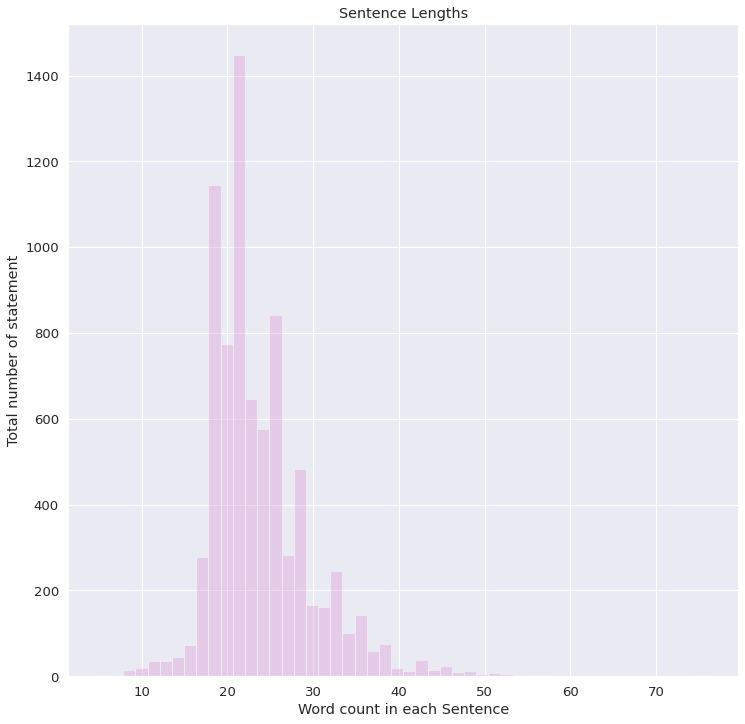

In [ ]:
sns.set(style='darkgrid')
# Increase the plot size and font size.
sns.set(font_scale=1.2)
plt.figure(figsize=(12,12))
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(TokenLength, kde=False, rug=False,color='plum')
plt.title('Sentence Lengths')
plt.xlabel('Word count in each Sentence')
plt.ylabel('Total number of statement');

**Adding Attention Mask**

In [ ]:
def token(statement):
  input_ids = []
  attention_masks = []
  for sent in statement:
      sent_str = ' '.join(sent)
      encoded_dict = tokenizer.encode_plus(
                          sent_str,                 
                          add_special_tokens = True,
                          truncation = True,
                          max_length = 80,           
                          pad_to_max_length = True,
                          return_attention_mask = True,   
                          return_tensors = 'pt',     
                    )
      input_ids.append(encoded_dict['input_ids'][0])
      attention_masks.append(encoded_dict['attention_mask'][0])
  return(input_ids,attention_masks)

In [ ]:
input_ids, attention_masks = token(statement)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


**Encoded Entity Labels**

In [ ]:
#Encoded Labels
#For "extra" tokens. 
null_label_id = -100 

def encode_label(input_ids, labels):
  new_labels = []
  for (sen, orig_labels) in zip(input_ids, labels):
      padded_labels = []
      orig_labels_i = 0 
      for token_id in sen:
          token_id = token_id.numpy().item()
          if (token_id == tokenizer.pad_token_id) or (token_id == tokenizer.cls_token_id) or (token_id == tokenizer.sep_token_id):
              padded_labels.append(null_label_id)
          elif tokenizer.ids_to_tokens[token_id][0:2] == '##':
              padded_labels.append(null_label_id)
          else:
              label_str = orig_labels[orig_labels_i]
              padded_labels.append(Labels[label_str])
              orig_labels_i += 1
      assert(len(sen) == len(padded_labels))    
      new_labels.append(padded_labels)
  return(new_labels)


In [ ]:
  new_labels=encode_label(input_ids, labels)

In [ ]:
print('\nSentence:    ', statement[5])
print('\nLabels:      ', labels[5])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(statement[5])))
print('\nToken IDs:   ', input_ids[5])
print('\nNew Labels:  ', new_labels[5])
print('\nMask:        ', attention_masks[5])


Sentence:     ['what', '1981', 'feature', 'film', 'starring', 'mel', 'gibson', 'takes', 'place', 'in', 'a', 'post', 'apocalyptic', 'world', 'in', 'australia']

Labels:       ['O', 'B-Year', 'O', 'O', 'O', 'B-Actor', 'I-Actor', 'B-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot', 'I-Plot']

BERT Tokens:  ['what', '1981', 'feature', 'film', 'starring', 'mel', 'gibson', 'takes', 'place', 'in', 'a', 'post', 'apocalyptic', 'world', 'in', 'australia']

Token IDs:    tensor([  101,  2054,  3261,  3444,  2143,  4626, 11463,  9406,  3138,  2173,
         1999,  1037,  2695, 27660,  2088,  1999,  2660,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,    

**Conversion of list into PyTorch tensors**

In [ ]:
pt_input_ids = torch.stack(input_ids, dim=0)
pt_attention_masks = torch.stack(attention_masks, dim=0)
pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [ ]:
pt_input_ids

tensor([[  101,  3889, 29265,  ...,     0,     0,     0],
        [  101, 20503,  8117,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  9805,  2140,  ...,     0,     0,     0],
        [  101,  9805,  2140,  ...,     0,     0,     0],
        [  101, 29250,  1041,  ...,     0,     0,     0]])

In [ ]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{} training samples'.format(train_size))
print('{} validation samples'.format(val_size))

7034 training samples
782 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
train_data = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size )
validation_data = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)

**BASEBERT model**

In [ ]:
from transformers import BertForTokenClassification, AdamW, BertConfig
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels = len(Labels) + 1, output_attentions = False, output_hidden_states = False)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

ADAM Optimization

In [ ]:
# Load the AdamW optimizer
ADAMoptimizer = AdamW(model.parameters(),
                  lr = 5e-5, # learning_rate 
                  eps = 1e-8 # adam_epsilon 
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs = 5

totalstp = len(train_data) * epochs
Hyperparameter = get_linear_schedule_with_warmup(ADAMoptimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = totalstp)

**Model Traing and validation**

In [ ]:
import random
loss_values = []
Valid_loss_values = []
for epoch_i in range(0, epochs):
    print('Training & validating for Epoch {} / {} ========'.format(epoch_i + 1, epochs))
    Tot_loss = 0
    model.train()
    for step, batch in enumerate(train_data):  # add batch to gpu
        if step % 50 == 0 and not step == 0:
            # Report progress.
            print('  Batch {}  of  {}.'.format(step, len(train_data)))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()     # clear any previously calculated gradients before performing a backward pass.   
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)        # forward pass
        loss = outputs[0]      # This will return the loss
        Tot_loss += loss.item()     # track train loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # prevent the "exploding gradients" problem.
        ADAMoptimizer.step() # update parameters
        Hyperparameter.step() # Update the learning rate.
    avg_train_loss = Tot_loss / len(train_data)            
    loss_values.append(avg_train_loss)
    print("  Average training loss: {}".format(avg_train_loss))

    model.eval()
    # The validation loss
    eval_loss=0
    nb_eval_steps=0
    for  batch in validation_data:  
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
          outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)    
        loss1 = outputs[0]    
        loss1 = loss1.detach().cpu().numpy()
        eval_loss += loss1.item()   
        nb_eval_steps += 1  
    eval_loss = eval_loss / nb_eval_steps          
    Valid_loss_values.append(eval_loss)
    print("  Average Validation loss: {}".format(eval_loss))


Training & validating for Epoch 1 / 5 ========
  Batch 50  of  220.
  Batch 100  of  220.
  Batch 150  of  220.
  Batch 200  of  220.
  Average training loss: 0.5711740360341289
  Average Validation loss: 0.36882447004318236
Training & validating for Epoch 2 / 5 ========
  Batch 50  of  220.
  Batch 100  of  220.
  Batch 150  of  220.
  Batch 200  of  220.
  Average training loss: 0.29241967993703755
  Average Validation loss: 0.34452819406986235
Training & validating for Epoch 3 / 5 ========
  Batch 50  of  220.
  Batch 100  of  220.
  Batch 150  of  220.
  Batch 200  of  220.
  Average training loss: 0.21992596228691666
  Average Validation loss: 0.3521013754606247
Training & validating for Epoch 4 / 5 ========
  Batch 50  of  220.
  Batch 100  of  220.
  Batch 150  of  220.
  Batch 200  of  220.
  Average training loss: 0.17357253256169233
  Average Validation loss: 0.3765241038799286
Training & validating for Epoch 5 / 5 ========
  Batch 50  of  220.
  Batch 100  of  220.
  Batch 1

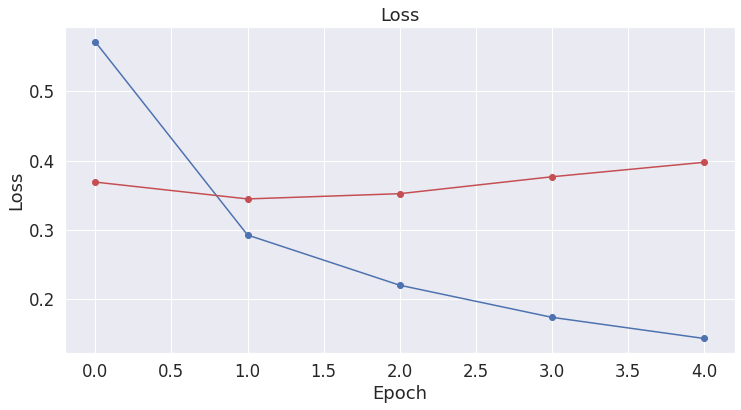

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o',label="Training loss")
plt.plot(Valid_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

**Test Data**

In [ ]:
#test data
statement,labels,unique_labels = read_data("./trivia10k13test.bio")

In [ ]:
input_ids = []
attention_masks = []
#Tokenization
input_ids, attention_masks = token(statement)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
new_labels=encode_label(input_ids, labels)

In [ ]:
pt_input_ids = torch.stack(input_ids, dim=0)
pt_attention_masks = torch.stack(attention_masks, dim=0)
pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [ ]:
batch_size = 32  
prediction_data = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
#prediction
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)


In [ ]:
# First, combine the results across the batches.
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0) 
predicted_label_ids = np.argmax(all_predictions, axis=2)

# Merge all to 1 value
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

print("  we have predictions:  ", predicted_label_ids.shape)

  we have predictions:   (148428,)


In [ ]:
# Construct new lists of predictions which don't include any null tokens.
real_token_predictions = []
real_token_labels = []

for i in range(len(all_true_labels)):
    if not all_true_labels[i] == -100:
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

print("Before filtering null tokens, length = {}".format(len(all_true_labels)))
print(" After filtering null tokens, length = {}".format(len(real_token_labels)))

Before filtering null tokens, length = 148428
 After filtering null tokens, length = 39033


**Performance Matrix**

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(real_token_labels, real_token_predictions, average='micro') 
print ("F1 score: {:.2%}".format(f1))

F1 score: 88.64%


In [ ]:
from sklearn import metrics
# Print the precision and recall, among other metrics
print(metrics.classification_report(real_token_labels, real_token_predictions, digits=2))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     14661
           1       0.74      0.76      0.75        66
           2       0.88      0.92      0.90       425
           3       0.72      0.77      0.75        44
           4       0.70      0.78      0.74       808
           5       0.73      0.75      0.74       283
           6       0.91      0.89      0.90     14143
           7       0.58      0.47      0.52        30
           8       0.85      0.86      0.85       347
           9       0.96      0.98      0.97      1274
          10       0.96      0.97      0.97      1553
          11       0.58      0.56      0.57      1577
          12       0.75      0.86      0.80       147
          13       1.00      0.38      0.55         8
          14       0.95      0.94      0.94       411
          15       0.44      0.27      0.33       143
          16       0.62      0.62      0.62       289
          17       0.74    